In [1]:
import pandas as pd

In [22]:
sothebysUS = pd.read_pickle("./sothebysUS.pkl")
sothebysUS["Image"] = sothebysUS["Collection"] + "_" + sothebysUS["LotNumber"]

In [23]:
sothebysUS

,Unnamed: 0,Origin,CurrencyType,AuctionDate,LotNumber,SoldPrice,Collection,ItemTitle,EstPriceInUSD,AllText,LogSoldPrice,PriceBin,input_ids,attention_mask,PriceBin_OneHot,Image
0,1,Louis Hayet,USD,2015-01-30T10:00:00.935-0500,582,28125,N09303,"LE CONCERT, TOGETHER WITH THREE OTHER WORKS",28125,gouache on paper moun...,10.244414,1,"[101, 2175, 6692, 5403, 2006, 3259, 5614, 2006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]",N09303_582
1,2,A light chestnut velvet-upholstered Knole sofa...,USD,2015-10-17T10:00:00.852-0400,807,5000,N09408,NaN,5000,height 45 1/2 in.; l...,8.517193,0,"[101, 4578, 3429, 1015, 1013, 1016, 1999, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]",N09408_807
2,3,"Chokwe Mask, Angola",USD,2015-04-20T10:00:00.589-0400,167,6000,N09333,NaN,6000,height: 9 3/8 in (23...,8.699515,0,"[101, 4578, 1024, 1023, 1017, 1013, 1022, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]",N09333_167
3,4,"Makonde Helmet Mask, Mozambique or Tanzania",USD,2015-04-20T10:00:00.589-0400,166,8125,N09333,NaN,8125,height: 9 3/4 in (24...,9.002701,0,"[101, 4578, 1024, 1023, 1017, 1013, 1018, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]",N09333_166
4,5,William Trost Richards,USD,2015-01-23T14:00:00.422-0500,272,12500,N09305,THE VALLEY STREAM,12500,signed w.t. richards...,9.433484,1,"[101, 2772, 1059, 1012, 1056, 1012, 9712, 1006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]",N09305_272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51644,140766,Frederick Marriott,USD,2009-03-18T11:00:00.000-0400,12,15000,D09003,ENGLISH,15000,signed f. marriott. ...,9.615805,1,"[101, 2772, 1042, 1012, 26490, 1012, 1998, 605...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]",D09003_12
51645,140767,Fabio Fabbi,USD,2009-03-18T11:00:00.000-0400,11,302500,D09003,ITALIAN,302500,signed fabio fabbi ...,12.619837,2,"[101, 2772, 25616, 6904, 10322, 2072, 1006, 28...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 1.0]",D09003_11
51646,140768,Fabio Fabbi,USD,2009-03-18T11:00:00.000-0400,10,80500,D09003,ITALIAN,80500,signed f. fabbi (lo...,11.296012,1,"[101, 2772, 1042, 1012, 6904, 10322, 2072, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]",D09003_10
51647,140769,Numa Marzocchi de Belluci,USD,2009-03-18T11:00:00.000-0400,1,122500,D09003,FRENCH,122500,signed n. marzocchi ...,11.715866,2,"[101, 2772, 1050, 1012, 9388, 6844, 25955, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 1.0]",D09003_1


In [38]:
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [26]:
imgSize = (128,128)
savepath = "./sothebysUSImg/"

In [18]:
# filepath = "/media/binli/HGST/Sothebys-Downloaded-Data-Legacy/allImages/"
# savepath = "./sothebysUSImg/"
# unfound = []


# for i, row in sothebysUS.iterrows():
#     try:
#         with Image.open(filepath+row["Image"] + ".jpg") as img: 
#             img = img.resize((128,128))
#             img.save(savepath + row["Image"] + ".jpg")
# #             img.show()
#     except:
#         unfound.append(row)
#         pass
    

In [34]:
sothebysUS["RawImg"] = sothebysUS["Image"].apply(lambda x: img_to_array(load_img(savepath+x+".jpg", target_size=imgSize)))

# Data processing, train test split

In [61]:
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Stratified train-test split
from sklearn.model_selection import StratifiedShuffleSplit
strata = sothebysUS["PriceBin"]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

for trainInd, testInd in sss.split(sothebysUS, strata):
    train = sothebysUS.iloc[trainInd,:]
    test = sothebysUS.iloc[testInd,:]
    
VAL_SIZE = int(len(train)*0.1)
print(f"train size is {len(train) - VAL_SIZE}")
print(f"validation size is {VAL_SIZE}")
print(f"test size is {len(test)}")

# # Use ordinal data label
# trainX = np.asarray(train["RawImg"][VAL_SIZE:].tolist())
# trainY = np.asarray(train["PriceBin"][VAL_SIZE:].tolist()).reshape(-1)

# valX = np.asarray(train["RawImg"][:VAL_SIZE].tolist())
# valY = np.asarray(train["PriceBin"][:VAL_SIZE].tolist()).reshape(-1)

# testX = np.asarray(test["RawImg"].tolist())
# testY = np.asarray(test["PriceBin"].tolist()).reshape(-1)

# Use one hot encode label
trainX = np.asarray(train["RawImg"][VAL_SIZE:].tolist())
trainY = np.asarray(train["PriceBin_OneHot"][VAL_SIZE:].tolist())

valX = np.asarray(train["RawImg"][:VAL_SIZE].tolist())
valY = np.asarray(train["PriceBin_OneHot"][:VAL_SIZE].tolist())

testX = np.asarray(test["RawImg"].tolist())
testY = np.asarray(test["PriceBin_OneHot"].tolist())

# sothebysUS.to_pickle("./sothebysUS.pkl")

train size is 41836
validation size is 4648
test size is 5165


In [99]:
comparePriceBin(trainY[0], trainY[2])

array([0, 0, 1])

In [112]:
[a, b] = np.empty((3, 2, 128,128))[0]

In [113]:
a.shape

(128, 128)

In [62]:
# data packing into TF dataset
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testY))
val_dataset = tf.data.Dataset.from_tensor_slices((valX, valY))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Model specification

In [76]:
import keras
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False # freeze base model

inputs = keras.Input(shape=(128, 128, 3))

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)

In [77]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization_3 (Normalizati (None, 128, 128, 3)       7         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 6147      
Total params: 23,593,866
Trainable params: 6,147
Non-trainable params: 23,587,719
___________________________________________

In [78]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)

In [84]:
epochs = 20
layerTrainHist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20
1308/1308 [==============================] - 47s 36ms/step - loss: 0.9706 - categorical_accuracy: 0.5004 - val_loss: 0.9996 - val_categorical_accuracy: 0.4778
Epoch 2/20
1308/1308 [==============================] - 49s 37ms/step - loss: 0.9706 - categorical_accuracy: 0.4994 - val_loss: 0.9964 - val_categorical_accuracy: 0.4839
Epoch 3/20
1308/1308 [==============================] - 49s 38ms/step - loss: 0.9703 - categorical_accuracy: 0.4997 - val_loss: 1.0033 - val_categorical_accuracy: 0.4748
Epoch 4/20
1308/1308 [==============================] - 49s 38ms/step - loss: 0.9690 - categorical_accuracy: 0.5011 - val_loss: 0.9988 - val_categorical_accuracy: 0.4755
Epoch 5/20
1308/1308 [==============================] - 49s 38ms/step - loss: 0.9702 - categorical_accuracy: 0.5020 - val_loss: 0.9985 - val_categorical_accuracy: 0.4830
Epoch 6/20
1308/1308 [==============================] - 49s 38ms/step - loss: 0.9703 - categorical_accuracy: 0.5000 - val_loss: 1.0046 - val_categoric

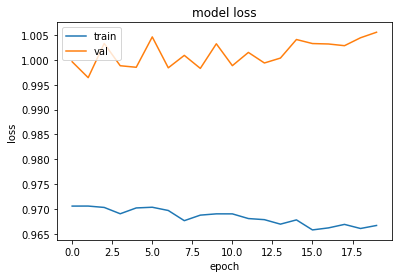

In [85]:
plt.plot(layerTrainHist.history['loss'])
plt.plot(layerTrainHist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

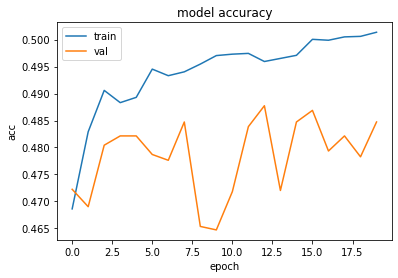

In [82]:
plt.plot(layerTrainHist.history['categorical_accuracy'])
plt.plot(layerTrainHist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)

epochs = 10
tuneHist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization_3 (Normalizati (None, 128, 128, 3)       7         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 6147      
Total params: 23,593,866
Trainable params: 23,540,739
Non-trainable params: 53,127
__________________________________________

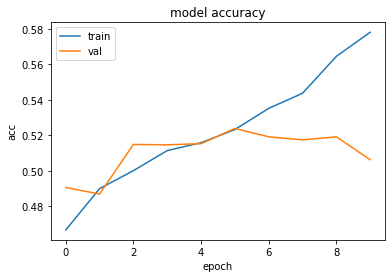

In [88]:
plt.plot(tuneHist.history['categorical_accuracy'])
plt.plot(tuneHist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

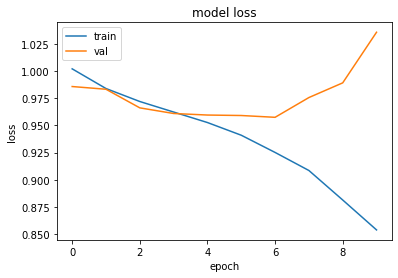

In [89]:
plt.plot(tuneHist.history['loss'])
plt.plot(tuneHist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [260]:
model.save("./sothebysResNet/")

INFO:tensorflow:Assets written to: ./sothebysResNet/assets


# Siamese CNN

## Data generator class, helper functions

In [111]:
def comparePriceBin(priceOnehot1, priceOnehot2):
    priceB1 = np.argmax(priceOnehot1)
    priceB2 = np.argmax(priceOnehot2)
    
    if (priceB1 == priceB2):
        return np.array([0,1,0])
    elif (priceB1 > priceB2):
        return np.array([1,0,0])
    else:
        return np.array([0,0,1])

In [199]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_data, labels, batch_size=32, dim=(128,128,3), n_inputs=2,
                 n_classes=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_data = list_data
        self.n_inputs = n_inputs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        index1 = np.random.choice(len(self.list_data), self.batch_size)
        index2 = np.random.choice(len(self.list_data), self.batch_size)

        # Generate data
        X, y = self.__data_generation(index1, index2)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self, index1, index2):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X1 = np.empty((self.batch_size, *self.dim))
        X2 = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for i in range(len(index1)):
            data1 = self.list_data[index1[i]]
            data2 = self.list_data[index2[i]]
            label1 = self.labels[index1[i]]
            label2 = self.labels[index2[i]]
            
            # Store sample
            X1[i,:] = data1
            X2[i,:] = data2

            # Store class
            y[i] = comparePriceBin(label1,label2)

        return [X1,X2], y


In [200]:
# Parameters
params = {'dim': (128,128,3),
          'batch_size': 32,
          'n_classes': 3,
          'n_inputs': 2,
          'shuffle': True}

# Generators
training_generator = DataGenerator(trainX, trainY, **params)
validation_generator = DataGenerator(valX, valY, **params)

In [255]:
from keras.layers import Concatenate, Subtract, Multiply, Dot, Dense, Dropout, GlobalMaxPool2D, GlobalAvgPool2D

def siameseCNN(input_shape, optimize, weight='imagenet'):
    left_input = keras.Input(input_shape)
    right_input = keras.Input(input_shape)
    
    base_model = keras.applications.ResNet50(
        weights=weight,  # Load weights pre-trained on ImageNet.
        input_shape=(128, 128, 3),
        include_top=False)
    base_model.trainable = True
    
    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    norm_layer.trainable = False
    # Scale inputs to [-1, +1]
    x1 = norm_layer(left_input)
    x2 = norm_layer(right_input)
    norm_layer.set_weights([mean, var])
    
    
    x1 = base_model(x1)
    x2 = base_model(x2)
    
    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    
    x3 = Subtract()([x1,x2])
    x3 = Multiply()([x3,x3])
    
    x1_ = Multiply()([x1,x1])
    x2_ = Multiply()([x2,x2])
    x4 = Subtract()([x1_,x2_])
    
    x5 = Dot(axes=-1, normalize=True)([x1, x2])
    
    x = Concatenate(axis=-1)([x5,x4,x3])
    x = Dense(1024, activation="relu")(x)
#     x = Dropout(0.01)(x)
#     out = Dense(3)(x)
    x = Dropout(0.2)(x)
    out = Dense(3, activation="softmax")(x)
    
    model = keras.Model([left_input, right_input], out)
    
    model.compile(
        optimizer=optimize,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy'],
    )
    
    model.summary()
    
    return model, base_model

In [238]:
# for keeping track the best model
checkpoint_filepath = './sothebysSiamCNN/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

opti = keras.optimizers.Adam(1e-5)

# prime the network by fixing base model's weight and train the added layer
sothebysSiam, siamBase = siameseCNN(input_shape = (128,128,3), optimize=opti)
# siamBase.trainable = False

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
normalization_15 (Normalization (None, 128, 128, 3)  7           input_46[0][0]                   
                                                                 input_47[0][0]                   
__________________________________________________________________________________________________
resnet50 (Model)                (None, 4, 4, 2048)   23587712    normalization_15[0][0]    

In [239]:
trainingHist = []

In [240]:
hist = sothebysSiam.fit(training_generator,
                           validation_data=validation_generator, 
                           epochs=20,
                          callbacks=[model_checkpoint_callback])
trainingHist.append(hist)

Epoch 1/20
1307/1307 [==============================] - 228s 175ms/step - loss: 20.4975 - categorical_accuracy: 0.3917 - val_loss: 16.2558 - val_categorical_accuracy: 0.3851
Epoch 2/20
1307/1307 [==============================] - 229s 175ms/step - loss: 11.5173 - categorical_accuracy: 0.4071 - val_loss: 11.0142 - val_categorical_accuracy: 0.3916
Epoch 3/20
1307/1307 [==============================] - 226s 173ms/step - loss: 7.8105 - categorical_accuracy: 0.4158 - val_loss: 7.7393 - val_categorical_accuracy: 0.3983
Epoch 4/20
1307/1307 [==============================] - 229s 175ms/step - loss: 4.6594 - categorical_accuracy: 0.4141 - val_loss: 5.3303 - val_categorical_accuracy: 0.4039
Epoch 5/20
1307/1307 [==============================] - 229s 175ms/step - loss: 2.7434 - categorical_accuracy: 0.4085 - val_loss: 2.3327 - val_categorical_accuracy: 0.3998
Epoch 6/20
1307/1307 [==============================] - 231s 176ms/step - loss: 1.8187 - categorical_accuracy: 0.4047 - val_loss: 1.7297

In [241]:
# The model weights (that are considered the best) are loaded into the model.
sothebysSiam.load_weights(checkpoint_filepath)

In [242]:
# train at lower learning rate
sothebysSiam.compile(
    optimizer=keras.optimizers.Adam(1e-6),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy'],
)

hist = sothebysSiam.fit(training_generator,
                           validation_data=validation_generator, 
                           epochs=10,
                          callbacks=[model_checkpoint_callback])
trainingHist.append(hist)

Epoch 1/10
1307/1307 [==============================] - 227s 174ms/step - loss: 0.9476 - categorical_accuracy: 0.5152 - val_loss: 1.0682 - val_categorical_accuracy: 0.4515
Epoch 2/10
1307/1307 [==============================] - 227s 174ms/step - loss: 0.9277 - categorical_accuracy: 0.5282 - val_loss: 1.0814 - val_categorical_accuracy: 0.4481
Epoch 3/10
1307/1307 [==============================] - 224s 172ms/step - loss: 0.9200 - categorical_accuracy: 0.5357 - val_loss: 1.0672 - val_categorical_accuracy: 0.4506
Epoch 4/10
1307/1307 [==============================] - 222s 170ms/step - loss: 0.9002 - categorical_accuracy: 0.5460 - val_loss: 1.0764 - val_categorical_accuracy: 0.4629
Epoch 5/10
1307/1307 [==============================] - 223s 170ms/step - loss: 0.8977 - categorical_accuracy: 0.5473 - val_loss: 1.0824 - val_categorical_accuracy: 0.4642
Epoch 6/10
1307/1307 [==============================] - 222s 170ms/step - loss: 0.8864 - categorical_accuracy: 0.5529 - val_loss: 1.0798 - v

In [244]:
# train at lower learning rate
sothebysSiam.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy'],
)

hist = sothebysSiam.fit(training_generator,
                           validation_data=validation_generator, 
                           epochs=10,
                          callbacks=[model_checkpoint_callback])
trainingHist.append(hist)

Epoch 1/10
1307/1307 [==============================] - 229s 175ms/step - loss: 0.7219 - categorical_accuracy: 0.6521 - val_loss: 1.3138 - val_categorical_accuracy: 0.4468
Epoch 2/10
1307/1307 [==============================] - 226s 173ms/step - loss: 0.6854 - categorical_accuracy: 0.6758 - val_loss: 1.3905 - val_categorical_accuracy: 0.4317
Epoch 3/10
1307/1307 [==============================] - 222s 170ms/step - loss: 0.6445 - categorical_accuracy: 0.7004 - val_loss: 1.3454 - val_categorical_accuracy: 0.4578
Epoch 4/10
1307/1307 [==============================] - 222s 170ms/step - loss: 0.6008 - categorical_accuracy: 0.7234 - val_loss: 1.4879 - val_categorical_accuracy: 0.4627
Epoch 5/10
1307/1307 [==============================] - 221s 169ms/step - loss: 0.5649 - categorical_accuracy: 0.7435 - val_loss: 1.6214 - val_categorical_accuracy: 0.4537
Epoch 6/10
1307/1307 [==============================] - 221s 169ms/step - loss: 0.5217 - categorical_accuracy: 0.7674 - val_loss: 1.6534 - v

In [250]:
def collapseHist(histlist, key):
    flatHist = []
    for hist in histlist:
        flatHist += hist.history[key]
    return flatHist

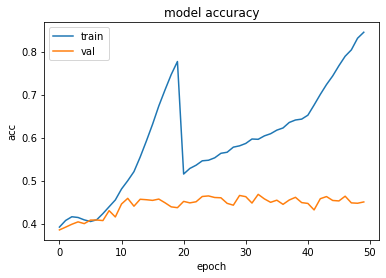

In [252]:
plt.plot(collapseHist(trainingHist, 'categorical_accuracy'))
plt.plot(collapseHist(trainingHist, 'val_categorical_accuracy'))
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

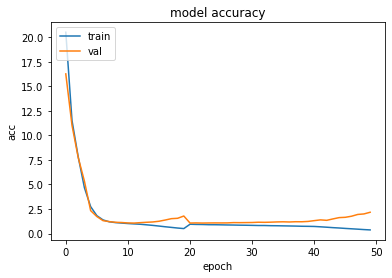

In [253]:
plt.plot(collapseHist(trainingHist, 'loss'))
plt.plot(collapseHist(trainingHist, 'val_loss'))
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [254]:

sothebysSiam.load_weights(checkpoint_filepath)
sothebysSiam.save("./sothebysSiamCNN/siamBestTransfer/")

INFO:tensorflow:Assets written to: ./sothebysSiamCNN/siamBestTransfer/assets


In [256]:
opti = keras.optimizers.Adam()

# retrain model without pretrain weight
sothebysSiam, siamBase = siameseCNN(input_shape = (128,128,3), optimize=opti, weight=None)
# siamBase.trainable = False

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
normalization_16 (Normalization (None, 128, 128, 3)  7           input_49[0][0]                   
                                                                 input_50[0][0]                   
__________________________________________________________________________________________________
resnet50 (Model)                (None, 4, 4, 2048)   23587712    normalization_16[0][0]    

In [257]:
trainingHist = []

In [258]:
hist = sothebysSiam.fit(training_generator,
                           validation_data=validation_generator, 
                           epochs=20,
                          callbacks=[model_checkpoint_callback])
trainingHist.append(hist)

Epoch 1/20
1307/1307 [==============================] - 228s 174ms/step - loss: 2.1292 - categorical_accuracy: 0.3752 - val_loss: 1.0930 - val_categorical_accuracy: 0.3903
Epoch 2/20
1307/1307 [==============================] - 227s 174ms/step - loss: 1.0837 - categorical_accuracy: 0.3959 - val_loss: 1.0571 - val_categorical_accuracy: 0.4166
Epoch 3/20
1307/1307 [==============================] - 221s 169ms/step - loss: 1.0655 - categorical_accuracy: 0.4125 - val_loss: 1.0578 - val_categorical_accuracy: 0.4306
Epoch 4/20
1307/1307 [==============================] - 228s 174ms/step - loss: 1.0586 - categorical_accuracy: 0.4223 - val_loss: 1.0700 - val_categorical_accuracy: 0.4093
Epoch 5/20
1307/1307 [==============================] - 229s 175ms/step - loss: 1.0528 - categorical_accuracy: 0.4250 - val_loss: 1.0599 - val_categorical_accuracy: 0.4218
Epoch 6/20
1307/1307 [==============================] - 224s 171ms/step - loss: 1.0470 - categorical_accuracy: 0.4355 - val_loss: 1.0572 - v

In [15]:
import keras

In [16]:
sothebysSiam = keras.models.load_model('./sothebysSiamCNN/siamBestTransfer/')

In [17]:
model = keras.models.load_model("./sothebysResNet/")

In [270]:
sothebysSiam.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
normalization_15 (Normalization (None, 128, 128, 3)  7           input_46[0][0]                   
                                                                 input_47[0][0]                   
__________________________________________________________________________________________________
resnet50 (Model)                (None, 4, 4, 2048)   23587712    normalization_15[0][0]    

In [19]:
import pandas as pd

In [21]:
sothebysUS = pd.read_pickle("./sothebysUS_rawImage.pkl")

In [22]:
sothebysUS.head(2)

,Unnamed: 0,Origin,CurrencyType,AuctionDate,LotNumber,SoldPrice,Collection,ItemTitle,EstPriceInUSD,AllText,LogSoldPrice,PriceBin,input_ids,attention_mask,PriceBin_OneHot,Image,RawImg
0,1,Louis Hayet,USD,2015-01-30T10:00:00.935-0500,582,28125,N09303,"LE CONCERT, TOGETHER WITH THREE OTHER WORKS",28125,gouache on paper moun...,10.244414,1,"[101, 2175, 6692, 5403, 2006, 3259, 5614, 2006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]",N09303_582,"[[[86.0, 68.0, 64.0], [100.0, 82.0, 78.0], [11..."
1,2,A light chestnut velvet-upholstered Knole sofa...,USD,2015-10-17T10:00:00.852-0400,807,5000,N09408,NaN,5000,height 45 1/2 in.; l...,8.517193,0,"[101, 4578, 3429, 1015, 1013, 1016, 1999, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]",N09408_807,"[[[254.0, 252.0, 255.0], [255.0, 254.0, 255.0]..."


In [24]:
img1 = sothebysUS["RawImg"][0].reshape(1, 128,128,3)
img2 = sothebysUS["RawImg"][1].reshape(1,128,128,3)

(128, 128, 3)

In [292]:
[layer.output for layer in sothebysSiam.layers[0:9]]

[<tf.Tensor 'input_46_1:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'input_47_1:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'normalization_15_2/Identity:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'conv5_block3_out_19/Identity:0' shape=(None, 4, 4, 2048) dtype=float32>,
 <tf.Tensor 'global_max_pooling2d_16_1/Identity:0' shape=(None, 2048) dtype=float32>,
 <tf.Tensor 'global_average_pooling2d_22_1/Identity:0' shape=(None, 2048) dtype=float32>,
 <tf.Tensor 'global_max_pooling2d_17_1/Identity:0' shape=(None, 2048) dtype=float32>,
 <tf.Tensor 'global_average_pooling2d_23_1/Identity:0' shape=(None, 2048) dtype=float32>,
 <tf.Tensor 'concatenate_25_1/Identity:0' shape=(None, 4096) dtype=float32>]

In [295]:
sothebysSiam.layers[8]

[<tf.Tensor 'input_46_1:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'input_47_1:0' shape=(None, 128, 128, 3) dtype=float32>]

In [23]:
siamExtractor = keras.Model(inputs=sothebysSiam.input,
                        outputs=sothebysSiam.layers[8].output)

In [313]:
features = siamExtractor([img1, img2])

In [314]:
features.numpy()

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
sothebysUS["SiamFeatures"] = sothebysUS["RawImg"].apply(lambda x: siamExtractor([x.reshape(1,128,128,3), img1]).numpy())

In [324]:
model.layers[3]

In [26]:
cnnExtractor = keras.Model(inputs=model.input,
                        outputs=model.layers[3].output)

In [27]:
sothebysUS["cnnFeatures"] = sothebysUS["RawImg"].apply(lambda x: cnnExtractor(x.reshape(1,128,128,3)).numpy())

In [28]:
sothebysUS_noRawImg = sothebysUS.drop("RawImg", axis=1)

In [29]:
sothebysUS_noRawImg.to_pickle("./sothebysUS_noRawImg.pkl")

In [2]:
import pandas as pd
sothebysUS = pd.read_pickle("./sothebysUS_noRawImg.pkl")

In [3]:
sothebysUS.head(2)

,Unnamed: 0,Origin,CurrencyType,AuctionDate,LotNumber,SoldPrice,Collection,ItemTitle,EstPriceInUSD,AllText,LogSoldPrice,PriceBin,input_ids,attention_mask,PriceBin_OneHot,Image,SiamFeatures,cnnFeatures
0,1,Louis Hayet,USD,2015-01-30T10:00:00.935-0500,582,28125,N09303,"LE CONCERT, TOGETHER WITH THREE OTHER WORKS",28125,gouache on paper moun...,10.244414,1,"[101, 2175, 6692, 5403, 2006, 3259, 5614, 2006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]",N09303_582,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.16779256, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2,A light chestnut velvet-upholstered Knole sofa...,USD,2015-10-17T10:00:00.852-0400,807,5000,N09408,NaN,5000,height 45 1/2 in.; l...,8.517193,0,"[101, 4578, 3429, 1015, 1013, 1016, 1999, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]",N09408_807,"[[0.0, 0.0, 0.21109672, 0.0, 0.0, 0.0, 0.0, 1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [7]:
import numpy as np
cnnMatrix = np.array(sothebysUS["cnnFeatures"].to_list())

In [12]:
cnnMatrix = cnnMatrix.reshape(-1,2048)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cnnMatrix = scaler.fit_transform(cnnMatrix)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cnnMatrix, 
                                                    sothebysUS["LogSoldPrice"], 
                                                    test_size=0.2, 
                                                    random_state=42)


In [29]:
from sklearn.linear_model import RidgeCV
cnnRidge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 5, 10], cv=10).fit(X_train, y_train)

/home/binli/enter/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.86515e-10): result may not be accurate.
  overwrite_a=True).T
/home/binli/enter/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.89564e-09): result may not be accurate.
  overwrite_a=True).T
/home/binli/enter/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.02961e-08): result may not be accurate.
  overwrite_a=True).T


In [30]:
X_train, X_test, y_train, y_test = train_test_split(sothebysUS[["SiamFeatures","cnnFeatures"]], 
                                                    sothebysUS["LogSoldPrice"], 
                                                    test_size=0.2, 
                                                    random_state=42)

(41319, 4096)

In [31]:
siamMatrix = np.array(X_train["SiamFeatures"].to_list())

In [33]:
siamMatrix = siamMatrix.reshape(-1,4096)

In [35]:
siamMatrix = scaler.fit_transform(siamMatrix)

In [36]:
siamRidge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 5, 10], cv=10).fit(siamMatrix, y_train)

/home/binli/enter/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.02437e-09): result may not be accurate.
  overwrite_a=True).T
/home/binli/enter/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.31179e-09): result may not be accurate.
  overwrite_a=True).T
/home/binli/enter/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.94054e-09): result may not be accurate.
  overwrite_a=True).T
/home/binli/enter/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.95353e-08): result may not be accurate.
  overwrite_a=True).T


In [37]:
siamcnnMatrix = np.array(X_train["cnnFeatures"].to_list())

In [39]:
siamcnnMatrix = siamcnnMatrix.reshape(-1,2048)

In [46]:
siamcnnMatrix = np.append(siamcnnMatrix, np.array(X_train["SiamFeatures"].to_list()).reshape(-1,4096), axis=1)

In [48]:
siamcnnMatrix = scaler.fit_transform(siamcnnMatrix)

In [ ]:
siamcnnRidge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 5, 10], cv=10).fit(siamcnnMatrix, y_train)